In [ ]:
pip install pykan

In [4]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from kan import *
from google.colab import files

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)




print(f'Using Pytorch version:{torch.__version__}')

if torch.cuda.is_available():
  print(f'Using GPU device: {torch.cuda.get_device_name(0)}')
  device = torch.device('cuda')
else:
  print('No GPU Found, using CPU instead')
  device = torch.device('cpu')

print('Using device:', device)


#### Training Dataset #####

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True, pin_memory=True)

#### Test dataset ####

test_dataset = datasets.MNIST(root='.', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, pin_memory=True)


Mounted at /content/drive
Using Pytorch version:2.3.0+cu121
No GPU Found, using CPU instead
Using device: cpu
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32450753.94it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1286023.46it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8572246.60it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6942612.52it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
#### Iterate over data ####


for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch ID = {batch_idx}")
    print(f"Data size = {data.size()}   Data type = {data.type()}")
    print(f"Target size = {target.size()}   Target type = {target.type()}")






Batch ID = 0
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target size = torch.Size([100])   Target type = torch.LongTensor
Batch ID = 1
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target size = torch.Size([100])   Target type = torch.LongTensor
Batch ID = 2
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target size = torch.Size([100])   Target type = torch.LongTensor
Batch ID = 3
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target size = torch.Size([100])   Target type = torch.LongTensor
Batch ID = 4
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target size = torch.Size([100])   Target type = torch.LongTensor
Batch ID = 5
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target size = torch.Size([100])   Target type = torch.LongTensor
Batch ID = 6
Data size = torch.Size([100, 1, 28, 28])   Data type = torch.FloatTensor
Target s

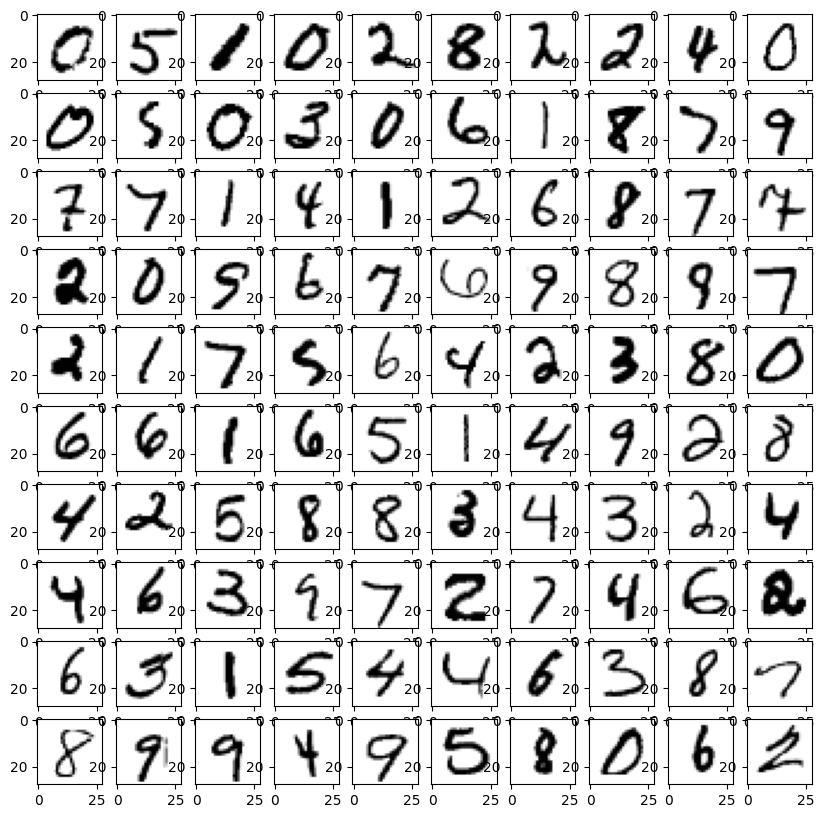

In [6]:
### print the first 100 digits ####
plt.figure(figsize = (10, 10))

for x in range(100):
    plt.subplot(10,10,x+1)
    plt.imshow(data[x,:,:,:].numpy().reshape(28,28),cmap="gray_r")

In [14]:
##### Implement KAN ######

model = KAN(width=[28*28,5,10], device = device)
model.to(device)


KAN(
  (biases): ModuleList(
    (0): Linear(in_features=5, out_features=1, bias=False)
    (1): Linear(in_features=10, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [15]:
######## Implement loss function (crossentropyloss) and optimizer (adam)

#### Setting the loss and the optimizer

Loss = nn.CrossEntropyLoss()

GD = torch.optim.Adam(model.parameters(), lr=1e-3)


#### Calculating correctly predicted labels ####

def correctly_predicted(output,target):
  predicted = torch.argmax(output, dim=1)
  correct_ones = (predicted==target).type(torch.float)
  return correct_ones.sum().item()


In [16]:

def train(data_loader,model,Loss,GD, start_epoch):



  num_batches = len(data_loader)
  num_samples = len(data_loader.dataset)

  total_loss = 0
  total_accurate = 0

  checkpoint_path = '/content/drive/MyDrive/mnist_model_checkpoint.pth'

  #model.train()

  for batch_idx, (data, target) in enumerate(data_loader):

    if batch_idx % 100 == 0:
            print(f"\n >>> Epoch {start_epoch}, Batch {batch_idx}")

    # Save checkpoint after every 100 batches
    if batch_idx > 0 and batch_idx % 100 == 0:
            print(f"\n Saving checkpoint for epoch {start_epoch}, batch {batch_idx}")
            checkpoint = {
                'epoch': start_epoch,
                'batch_idx': batch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': GD.state_dict(),
                'train_loss': total_loss / (batch_idx + 1),  # Average loss up to current batch
                'accuracy': total_accurate / ((batch_idx + 1) * data.size(0))  # Average accuracy up to current batch
            }
            torch.save(checkpoint, checkpoint_path)
            #files.download(checkpoint_path)
            print(f"Checkpoint saved and downloaded on local for epoch {start_epoch}, batch {batch_idx}")

    ## copy to device
    data = data.view(-1, 28 * 28).to(device)
    target = target.to(device)

    #print(f"Length of data = {len(data)} and that of target is {len(target)}")

    ### forward pass
    output = model(data)
    #print(f"Length of output = {len(output)}")

    ### Calculate loss ###
    #output_singular = torch.argmax(output, dim=1)
    #target_float = target.float()
    batch_loss = Loss(output,target)
    total_loss += batch_loss.item()

    ### Count correctly predicted labels###
    correctly_predicted_count = correctly_predicted(output,target)
    total_accurate += correctly_predicted_count

    ### backward propagation
    GD.zero_grad()
    batch_loss.backward()
    GD.step()




  train_loss = total_loss/num_batches
  accuracy = total_accurate/num_samples
  print(f"Average loss: {train_loss:4f}, accuracy: {accuracy:.2%}")




In [17]:

epochs = 10
for i in range(epochs):
  print(f"Traning Start: EPOCH number: {i+1}")
  train(train_loader, model, Loss, GD, i+1)


Traning Start: EPOCH number: 1

 >>> Epoch 1, Batch 0

 >>> Epoch 1, Batch 100

 Saving checkpoint for epoch 1, batch 100
Checkpoint saved and downloaded on local for epoch 1, batch 100

 >>> Epoch 1, Batch 200

 Saving checkpoint for epoch 1, batch 200
Checkpoint saved and downloaded on local for epoch 1, batch 200

 >>> Epoch 1, Batch 300

 Saving checkpoint for epoch 1, batch 300
Checkpoint saved and downloaded on local for epoch 1, batch 300

 >>> Epoch 1, Batch 400

 Saving checkpoint for epoch 1, batch 400
Checkpoint saved and downloaded on local for epoch 1, batch 400

 >>> Epoch 1, Batch 500

 Saving checkpoint for epoch 1, batch 500
Checkpoint saved and downloaded on local for epoch 1, batch 500
Average loss: 1.831272, accuracy: 44.19%
Traning Start: EPOCH number: 2

 >>> Epoch 2, Batch 0

 >>> Epoch 2, Batch 100

 Saving checkpoint for epoch 2, batch 100
Checkpoint saved and downloaded on local for epoch 2, batch 100

 >>> Epoch 2, Batch 200

 Saving checkpoint for epoch 2, b

In [22]:
### Testing #####

def test(data_loader,model,Loss,GD):

  #model.eval()

  num_batches_test = len(data_loader)
  num_samples_test = len(data_loader.dataset)

  total_loss_test = 0
  total_accurate_test = 0



  for batch_idx, (data, target) in enumerate(data_loader):

    print(f"Batch ID = {batch_idx}")
    ## copy to device
    data = data.view(-1, 28 * 28).to(device)
    target = target.to(device)



    ### forward pass
    output = model(data)
    #print(f"Length of output = {len(output)}")

    ### Calculate loss ###
    batch_loss = Loss(output,target)
    total_loss_test += batch_loss

    ### Count correctly predicted labels###
    correctly_predicted_count = correctly_predicted(output,target)
    total_accurate_test += correctly_predicted_count


  test_loss = total_loss_test/num_batches_test
  accuracy_test = total_accurate_test/num_samples_test
  print(f"Average loss: {test_loss:4f}, accuracy: {accuracy_test:.2%}")


test(test_loader,model,Loss,GD)

Batch ID = 0
Batch ID = 1
Batch ID = 2
Batch ID = 3
Batch ID = 4
Batch ID = 5
Batch ID = 6
Batch ID = 7
Batch ID = 8
Batch ID = 9
Batch ID = 10
Batch ID = 11
Batch ID = 12
Batch ID = 13
Batch ID = 14
Batch ID = 15
Batch ID = 16
Batch ID = 17
Batch ID = 18
Batch ID = 19
Batch ID = 20
Batch ID = 21
Batch ID = 22
Batch ID = 23
Batch ID = 24
Batch ID = 25
Batch ID = 26
Batch ID = 27
Batch ID = 28
Batch ID = 29
Batch ID = 30
Batch ID = 31
Batch ID = 32
Batch ID = 33
Batch ID = 34
Batch ID = 35
Batch ID = 36
Batch ID = 37
Batch ID = 38
Batch ID = 39
Batch ID = 40
Batch ID = 41
Batch ID = 42
Batch ID = 43
Batch ID = 44
Batch ID = 45
Batch ID = 46
Batch ID = 47
Batch ID = 48
Batch ID = 49
Batch ID = 50
Batch ID = 51
Batch ID = 52
Batch ID = 53
Batch ID = 54
Batch ID = 55
Batch ID = 56
Batch ID = 57
Batch ID = 58
Batch ID = 59
Batch ID = 60
Batch ID = 61
Batch ID = 62
Batch ID = 63
Batch ID = 64
Batch ID = 65
Batch ID = 66
Batch ID = 67
Batch ID = 68
Batch ID = 69
Batch ID = 70
Batch ID = 71
Ba

In [ ]:
###### print the model file to see visually ####

checkpoint = torch.load('mnist_model_checkpoint.pth')

# Print the keys and some of the values
for key, value in checkpoint.items():
    print(f"{key}: {value}")

epoch: 1
batch_idx: 2
model_state_dict: OrderedDict([('biases.0.weight', tensor([[ 0.0014, -0.0008, -0.0019, -0.0014,  0.0019,  0.0016,  0.0019, -0.0019,
          0.0019,  0.0019, -0.0020, -0.0019, -0.0019,  0.0019,  0.0018,  0.0020,
          0.0020,  0.0006, -0.0015,  0.0016]])), ('biases.1.weight', tensor([[-0.0020,  0.0003, -0.0020,  0.0020, -0.0006, -0.0015,  0.0020,  0.0014,
          0.0004,  0.0020]])), ('act_fun.0.grid', tensor([[-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000],
        ...,
        [-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000]])), ('act_fun.0.coef', tensor([[ 0.0007,  0.0011, -0.0030,  0.0223, -0.0149, -0.0060],
        [-0.0094, -0.0260,  0.0309,  0.0056,  0.0060,  0.0016],
        [ 0.0001, -0.0006, -0.0105, -0.0028,  0.0231,  0.0059],
        ...,
        [-0.0016,  0.0040,  0.0283, -0.0151, -0.0